In [1]:
import numpy as np
import matplotlib as plt
from micrograd.engine import Value
from graphviz import Digraph

In [2]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### Simple graph
$e = a*b + c$

In [3]:
a = Value(-4.0)
b = Value(2.0)
c = Value(1.0)

e = a * b + c
e

Value(data=-7.0, grad=0)

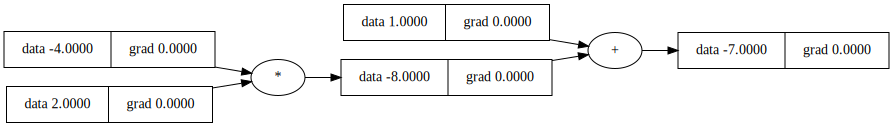

In [4]:
draw_dot(e)

### Bit complex graph
$c = a + b$<br>
$e = a*d$<br>
$L = c * e$<br><br>
If $L = f(c, e)$
then, $\frac{\partial L}{\partial a} = \frac{\partial L}{\partial f}*\frac{\partial f}{\partial c}*\frac{\partial c}{\partial a} + \frac{\partial L}{\partial f}*\frac{\partial f}{\partial e}*\frac{\partial e}{\partial a}$<br><br>
Since $\frac{\partial L}{\partial f} = 1$, because $L$ is the output of the function $f$<br><br>
$\frac{\partial L}{\partial a} = \frac{\partial f}{\partial c}*\frac{\partial c}{\partial a} + \frac{\partial f}{\partial e}*\frac{\partial e}{\partial a}$<br><br>
Intutively, the effect of $a$ on $L$ is the sum of the effect of $a$ on $L$ via $c$ and the effect of $a$ on $L$ via $e$.<br><br>
So, whenever a variable is going to be used more than once in the graph, we need to sum the effect of that variable on the output via all the paths it is connected to the output.

##### Multivariable chain rule
$    \underbrace{
        \dfrac{d}{dt} f(\blueD{x}(t), \redE{y}(t))
    }_{\text{Derivative of composition function}} 
    \!\!\!\!\!\! = 
    \dfrac{\partial f}{\partial \blueD{x}} \dfrac{d\blueD{x}}{dt} + 
    \dfrac{\partial f}{\partial \redE{y}} \dfrac{d\redE{y}}{dt} 
$

In [16]:
a = Value(-4.0)
b = Value(2.0)
d = Value(3.0)
c = a + b
e = a*d
L = c * e

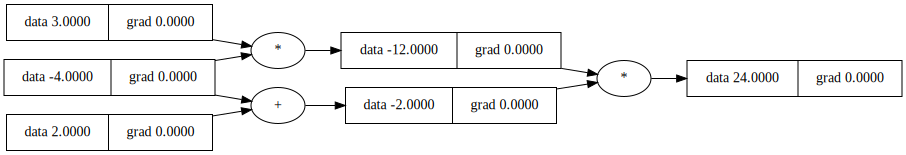

In [17]:
draw_dot(L)

##### Manual backprop

In [18]:
L.grad = 1.0

In [19]:
# dL / dc = e
# dL / de = c
c.grad = e.data
e.grad = c.data

In [20]:
# dL / db = dL / dc * dc / db = dL / dc
# dL / dd = dL / de * de / dd = dL / de * a
b.grad = c.grad
d.grad = e.grad * a.data

In [21]:
# dL / da = dL / dc * dc / da + dL / de * de / da = dL / dc + dL / de * d
a.grad = c.grad * 1.0 + e.grad * d.data

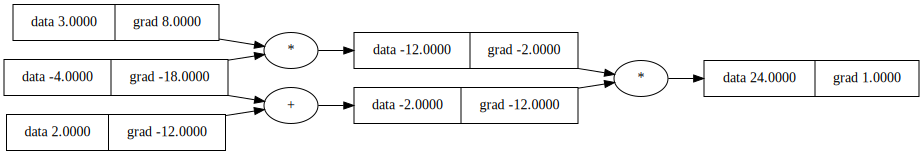

In [22]:
draw_dot(L)

##### Inbuilt backprop

In [23]:
a = Value(-4.0)
b = Value(2.0)
d = Value(3.0)
c = a + b
e = a*d
L = c * e
L.backward()

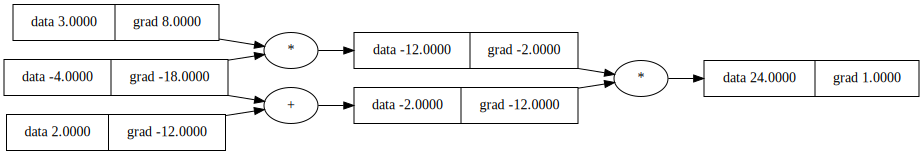

In [24]:
draw_dot(L)

In [21]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(L)
for v in reversed(topo):
    print(v)

Value(data=24.0, grad=1)
Value(data=-12.0, grad=-2.0)
Value(data=3.0, grad=8.0)
Value(data=-2.0, grad=-12.0)
Value(data=2.0, grad=-12.0)
Value(data=-4.0, grad=-18.0)


##### Note
`_backward` is a function which just defines how to calculate the gradient of the inputs using the gradient of the output.

In [35]:
# Question: What will this function do?
# Answer: Nothing
some_fn = lambda: None

In [36]:
print(some_fn())

None


#### Try to implement a simple array operation using micrograd

In [25]:
np.array([[Value(1.0), Value(2.0)], [Value(3.0), Value(4.0)]])

array([[Value(data=1.0, grad=0), Value(data=2.0, grad=0)],
       [Value(data=3.0, grad=0), Value(data=4.0, grad=0)]], dtype=object)

In [31]:
def np_array_of_vals(shape):
    """
    shape: tuple of integers
    Example: if shape = (2, 2, 2), then the function should return a 2x2x2 numpy array of Value objects.
    All the numbers should be initialized by np.random.randn
    """
    if len(shape) == 1:
        return np.array([Value(np.random.randn()) for _ in range(shape[0])])
    return np.array([np_array_of_vals(shape[1:]) for _ in range(shape[0])])

In [40]:
x = np_array_of_vals((2,))
x

array([Value(data=-0.13268506605899344, grad=0),
       Value(data=-1.3134656075351403, grad=0)], dtype=object)

In [41]:
W = np_array_of_vals((2, 2))
W

array([[Value(data=-0.49191286783292015, grad=0),
        Value(data=-0.6490037395901154, grad=0)],
       [Value(data=0.6453560018491445, grad=0),
        Value(data=-0.18756903538124506, grad=0)]], dtype=object)

In [42]:
b = np_array_of_vals((2,))
b

array([Value(data=-2.0421927133243223, grad=0),
       Value(data=1.0490711488648026, grad=0)], dtype=object)

In [43]:
a = x @ W + b
a

array([Value(data=-2.824576135005878, grad=0),
       Value(data=1.3815497299366581, grad=0)], dtype=object)

In [44]:
s = np.sum(a)
s

Value(data=-1.4430264050692199, grad=0)

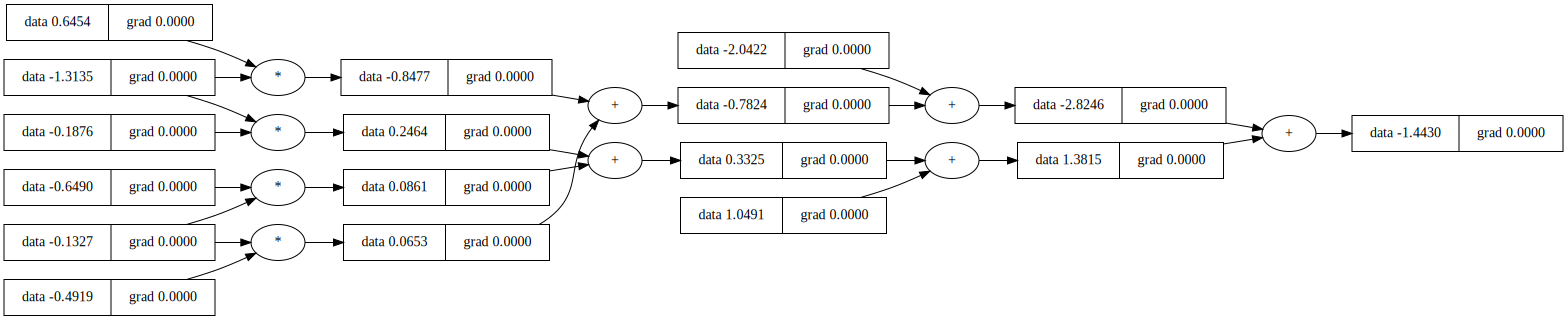

In [45]:
draw_dot(s)

In [46]:
s.backward()

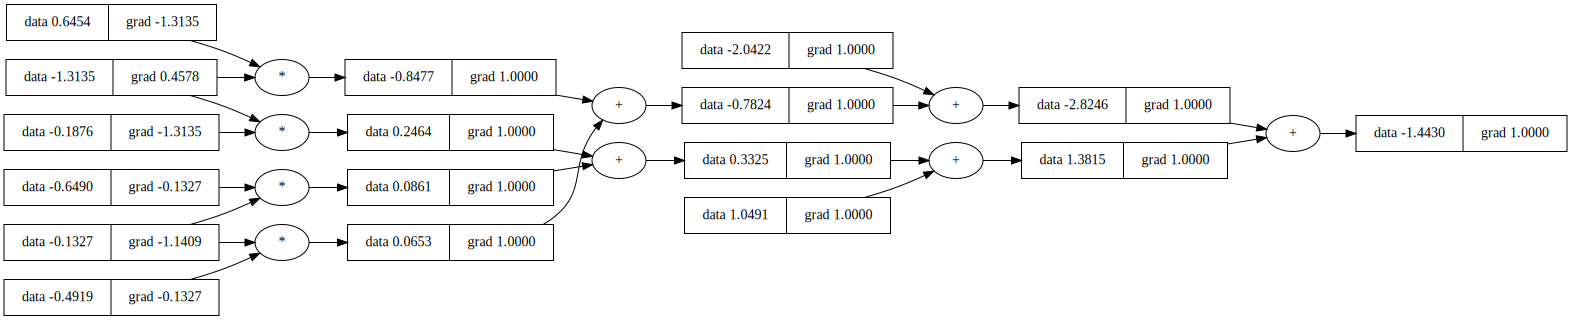

In [47]:
draw_dot(s)

#### Try to make a cycle

In [50]:
a = Value(2.0)
b = a + 3.0
c = b * 2.0
a = c + 4

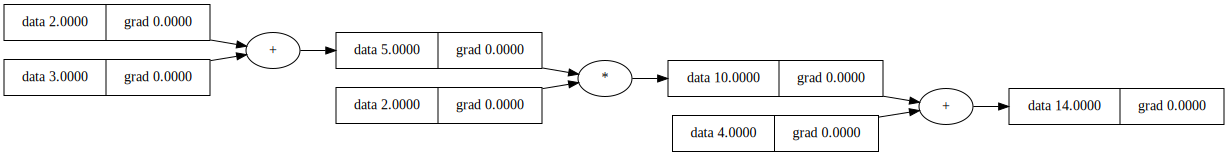

In [51]:
draw_dot(a)
# It won't form a cycle because for every operation, new nodes are being created

#### Important
Set the gradients of all the weights (`Value` objects) to 0 before starting the backpropagation.<br>
In `pytorch`, this is called `zero_grad()`.